# Hybrid - Part 3: Semi-supervised Learning Dataset Text Pre-Processing & Representation

**Environment Setup**

In [1]:
#Loading key libraries for later analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
pd.set_option('max_colwidth', 1000)
!pip install spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
!pip install gensim
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate,StratifiedKFold,GridSearchCV,train_test_split
from sklearn.metrics import confusion_matrix, classification_report,mean_squared_error,accuracy_score
!pip install xgboost
import xgboost as xgb
import sklearn   
import scipy.io as scio
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
import os
!pip install bert-serving-server 
!pip install bert-serving-client
import functions
from gensim.scripts.glove2word2vec import glove2word2vec


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.       

  Using cached bert_serving_server-1.10.0-py3-none-any.whl (61 kB)
Processing /home/faculty/.cache/pip/wheels/79/c1/b2/b6fc2647f693a084da25e1d31328ab3dbb565cc58fea37e973/GPUtil-1.4.0-py3-none-any.whl

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached bert_serving_client-1.10.0-py2.py3-none-any.whl (28 kB)


In [30]:
#Read in bank transactions
df = pd.read_csv(r'df_postfeat_no_direct_FINAL.csv',low_memory=False,encoding='latin1')
df1 = pd.read_csv(r'df_post_weak_label_updated.csv',low_memory=False,encoding='latin1')

In [6]:
#External resources
stopwords = pd.read_csv(r'stopwords.csv',low_memory=False,encoding='latin1')
abb = pd.read_csv(r'normalisation.csv',low_memory=False,encoding='latin1')

In [4]:
import os
os.getcwd()

'/project'

## 1. Text Preprocessing

In [31]:
#Stopword and special character Removals
functions.removals(df,stopwords,'description')
df.description = df.description.replace('\s+', ' ', regex=True)
df = df[df['description'] != '']

#Text Normalisation
functions.abbrivations(df,'description')

#Tokenisation and Lemmatisation
df.loc[:,'description'] = functions.tokenise_lemmatise(df,'description')

# count the number of tokens of each description
df['token_length'] = [len(token) for token in df.description]
df = df[df['token_length']!=0].reset_index(drop=True)

## 2. Prepare Final Dataset

### 2.1 Exploration

In [35]:
#Transfer the weak labels to the final dataframe
df['weak_label'] = df1['weak_label']

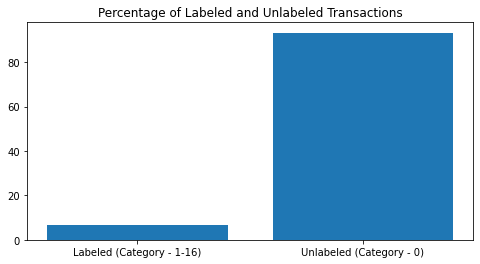

In [36]:
#Exploration of the final dataframe: distribution of labelled and unlabelled transactions
a1 = len(df[df['weak_label']!=0])/len(df)*100
a2 = len(df[df['weak_label']==0])/len(df)*100
X = [a1,a2]

plt.figure(figsize=(8,4))

plt.bar(range(2), X)
plt.xticks(range(2), ['Labeled (Category - 1-16)','Unlabeled (Category - 0)'])
plt.title("Percentage of Labeled and Unlabeled Transactions")
plt.savefig(r'Percentage of Labeled and Unlabeled Transactions(after semi).png',bbox_inches='tight')

The number of labels by category:
0     106727
1        915
2         41
3       1366
4         30
5         68
6        219
7        816
8        211
9         42
10       330
11      1096
12        62
13      2370
14        50
15         8
16        18
Name: weak_label, dtype: int64


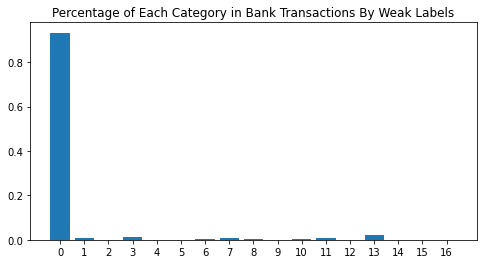

In [37]:
#Exploration of final dataframe: Distribution of each class in the final dataframe
print('The number of labels by category:')
print(df['weak_label'].value_counts().sort_index())
a1 = df['weak_label'].value_counts().sort_index()
X = [(x/(df['weak_label'].notnull().sum())) for x in a1 ]

plt.figure(figsize=(8,4))

plt.bar(range(17), X)
plt.xticks(range(17), list(range(17)))
plt.title("Percentage of Each Category in Bank Transactions By Weak Labels")
plt.savefig(r'Percentage of Each Category in Bank Transactions By Weak Labels.png',bbox_inches='tight')

### 2.2 Create Final dataframe

In [38]:
final_df = df.loc[:,['amount', 'balance', 'description', 'debit_binary', 'foreign_binary', 'financing_binary', 'account_binary', 'hmrc_vat',
       'hmrc_corp', 'hmrc_paye', 'token_length','week_of_month_2','week_of_month_3','week_of_month_4','weak_label']]

### 2.3 Undersampling

Because we've observed that unlabelled transaction is more than 90% of overall transactions and in order to improve model performance we could undersample the unlabelled to form a more balanced dataframe

In [40]:
#Number of labelled transactions
l = final_df[final_df.weak_label != 0]

def undersamp_per(df1,num,p):
    #Choose the amount of unlabelled transactions
    u = df1[df1.weak_label == 0].sample(round((num/(1-p))*p),random_state=42)
    #match the two together: labelled and unlabelled
    f_p = pd.concat([l,u])
    return f_p

#Form a final dataframe that labelled and unlabelled: 40:60
df_4 = undersamp_per(final_df,len(l),0.4)

In [41]:
df_4.index

Int64Index([    11,     21,     26,     29,     35,     36,     42,     60,
                70,     75,
            ...
             63107,   2708,  60899,   7233, 101412,  16402,   8617,  97329,
             16487,  72665],
           dtype='int64', length=12737)

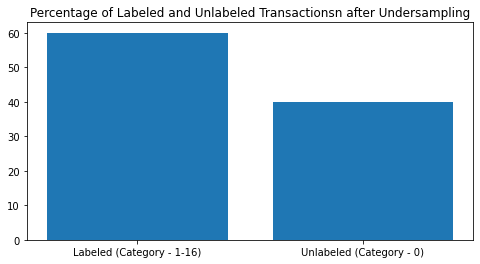

In [42]:
#Plot the graph after undersampling: unlabelled: labelled
a1 = len(df_4[df_4['weak_label']!=0])/len(df_4)*100
a2 = len(df_4[df_4['weak_label']==0])/len(df_4)*100
X = [a1,a2]

plt.figure(figsize=(8,4))

plt.bar(range(2), X)
plt.xticks(range(2), ['Labeled (Category - 1-16)','Unlabeled (Category - 0)'])
plt.title("Percentage of Labeled and Unlabeled Transactionsn after Undersampling")
plt.savefig(r'L U ratio after undersampling.png',bbox_inches='tight')

The number of labels by category:
0     5095
1      915
2       41
3     1366
4       30
5       68
6      219
7      816
8      211
9       42
10     330
11    1096
12      62
13    2370
14      50
15       8
16      18
Name: weak_label, dtype: int64


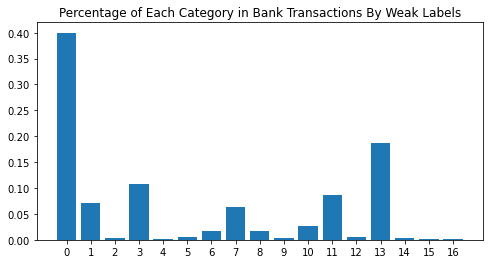

In [43]:
#check distributino of final dataframe
print('The number of labels by category:')
print(df_4['weak_label'].value_counts().sort_index())
a1 = df_4['weak_label'].value_counts().sort_index()
X = [(x/(df_4['weak_label'].notnull().sum())) for x in a1 ]

plt.figure(figsize=(8,4))

plt.bar(range(17), X)
plt.xticks(range(17), list(range(17)))
plt.title("Percentage of Each Category in Bank Transactions By Weak Labels")
plt.show()

### 2.4 Train Test Split

In [44]:
#Get the X,y in final dataframe
X = df_4.iloc[:,:-1]
y = df_4.iloc[:,-1]

In [45]:
#Train, testing dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
train_indices = X_train.index
test_indices = X_test.index

## 3. Word Representation

In [47]:
#join descriptions of the training data
X_train_des = [' '.join(x) for x in X_train['description']]

### 3.1 Frequency-based Methods

In [48]:
svc = SVC(random_state=200)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

#Check the optimal nummber of n-grams
def count_vect(df,x):
    ngram = list()
    for n in range(1,6):
        #form mixing n-gram
        if x >0 :
            bow =  CountVectorizer(ngram_range=(1,n))
            tfidf=  TfidfVectorizer(ngram_range=(1,n))
            i = (1,n)
        #form single n-gram
        else:
            bow =  CountVectorizer(ngram_range=(n,n))
            tfidf=  TfidfVectorizer(ngram_range=(n,n))
            i = (n,n)
            
        tfidf_matrix = tfidf.fit_transform(df)
        bow_matrix = bow.fit_transform(df)
        tfidf_cv = cross_val_score(svc, tfidf_matrix, y_train, cv=kfold, scoring='f1_macro').mean()
        bow_cv = cross_val_score(svc, bow_matrix, y_train, cv=kfold, scoring='f1_macro').mean()
        print('n-gram :{}, Bag of Words F1 Score: {},TF-iDF F1 Score: {} '.format(i,bow_cv,tfidf_cv))
        ngram.append({'n': n, 'score': tfidf_cv, 'type': 'TF-iDF'})
        ngram.append({'n': n, 'score': bow_cv, 'type': 'Bag of Words'})
    return pd.DataFrame(ngram)

In [49]:
#check f1 score of mixing n-grams
n_gram_1 = count_vect(X_train_des,1)

n-gram :(1, 1), Bag of Words F1 Score: 0.8686003789159564,TF-iDF F1 Score: 0.8636055392294093 
n-gram :(1, 2), Bag of Words F1 Score: 0.8691464793491217,TF-iDF F1 Score: 0.8699559838755644 
n-gram :(1, 3), Bag of Words F1 Score: 0.8686656275119005,TF-iDF F1 Score: 0.867564150404857 
n-gram :(1, 4), Bag of Words F1 Score: 0.8670711965332126,TF-iDF F1 Score: 0.8656821446548871 
n-gram :(1, 5), Bag of Words F1 Score: 0.8597541027329203,TF-iDF F1 Score: 0.8632766255080947 


In [50]:
#check f1 score of single n-grams
n_gram_2 = count_vect(X_train_des,0)

n-gram :(1, 1), Bag of Words F1 Score: 0.8686003789159564,TF-iDF F1 Score: 0.8636055392294093 
n-gram :(2, 2), Bag of Words F1 Score: 0.8372357223693385,TF-iDF F1 Score: 0.8404366792662475 
n-gram :(3, 3), Bag of Words F1 Score: 0.6955604374115207,TF-iDF F1 Score: 0.6961536605949896 
n-gram :(4, 4), Bag of Words F1 Score: 0.5138674452026188,TF-iDF F1 Score: 0.5185291419478665 
n-gram :(5, 5), Bag of Words F1 Score: 0.4497132904439507,TF-iDF F1 Score: 0.4506423133641094 


In [51]:
#plot the graph of n-grams and its f1 score
def plot_count(df):
    plt.figure(figsize=(10,4))
    a= df[df['type']=='Bag of Words']
    b= df[df['type']=='TF-iDF']

    #Plot line graphs
    plt.plot(a['n'], a['score'], label= "Bag of Words",color='steelblue',linewidth=3)
    plt.plot(b['n'], b['score'], label="TF-IDF",color='skyblue',linewidth=3)

    #Format plot
    plt.xlabel('n-grams')
    plt.ylabel('F1 Score')
    plt.title("BoW and TF-iDF Performance by n-gram values")
    plt.legend()
    plt.show()

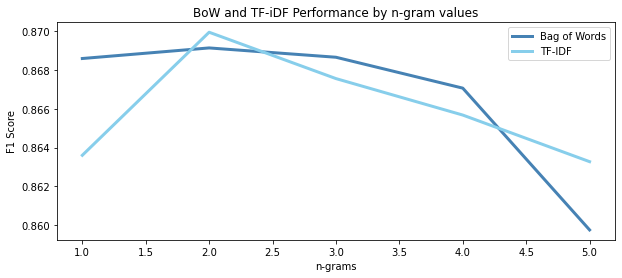

In [52]:
#mixed n-grams plot
plot_count(n_gram_1)

In [53]:
svc = SVC(random_state=200)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

#check the maximum feature number for optimal model and its n-gram
def max_feat(index,model,model_name):
    vec =  model(ngram_range=index)
    vec_matrix = vec.fit_transform(X_train_des)
    #get the total number of features in the model without any deductions
    a = vec_matrix.shape
    
    #generate f1 scors with different maxmium number of features 
    vec_result = list()
    for n in range(500, a[1], 1000):
        vec = model(ngram_range=index,max_features=n)
        vec_matrix = vec.fit_transform(X_train_des)
        score_countVec = cross_val_score(svc, vec_matrix, y_train, cv=kfold, scoring='f1_macro').mean()

        vec_result.append({'max_feature': n,  'score': score_countVec})
    print('finished')
    
    #plot the graph of different f1 score with different max features
    vec_result_df = pd.DataFrame(vec_result)
    plt.figure(figsize=(10,4))
    #Plot line graphs
    plt.plot(vec_result_df['max_feature'], vec_result_df['score'],color='steelblue',linewidth=3)
    #Format plot
    plt.xlabel('Number of features')
    plt.ylabel('F1 Score')
    plt.title("Maximum Number of Features in {}".format(model_name))
    plt.show()
    
    max_score = vec_result_df['score'].max()
    a = vec_result_df[vec_result_df['score'] == max_score]
    a = a.iloc[0]['max_feature']
    print('maximum feature is {}'.format(a))

finished


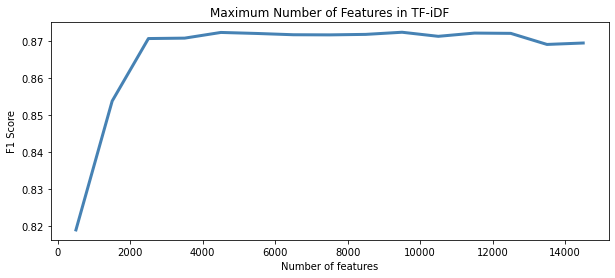

maximum feature is 9500.0


In [54]:
#plot the graph with the optimal model and n-gram
max_feat((1,2),TfidfVectorizer,'TF-iDF')

In [57]:
#Form the final model for frequency-based models
tf = TfidfVectorizer(ngram_range=(1,2),max_features=9500)
tf_matrix = tf.fit_transform(X_train_des)

### 3.2 Model-based Methods

**3.2.1 Word2vec: Self-trained**

In [37]:
#Turn description to list for modelling
X_train_list = X_train['description'].tolist()

In [38]:
#load and save the model
word2vec_self_model = Word2Vec(X_train_list, size=300, window=5, min_count=2, iter=100)

word2vec_self_model.save(r'word2vec_self.w2v')
word2vec_self_model.wv.save_word2vec_format(r'word2vec_self.bin',binary=False)

#reload the model
word2vec_self = word2vec_self_model.wv.load_word2vec_format(r'word2vec_self.bin',binary=False)

In [39]:
#vectorise training descriptions using self-trained tokens 
def w2v_vectorise(texts, word2vec_model):
        i = 0
        index2word_set = set(word2vec_model.index2word)
        description_vector = np.zeros((word2vec_model.vector_size))
        for text in texts:
                if text in index2word_set:
                        description_vector = np.add(description_vector, word2vec_model[text])
                        i += 1
        text_vector = np.divide(description_vector, i)
        return text_vector

startTime = time.time()
vector_list = []
i = 0
for texts in X_train_list:
        i += 1
        if i % 3000 == 0: 
                print('%.2fs used for generating word embeddings for top %d transaction description' %(time.time()-startTime,i))
        vector_list.append(w2v_vectorise(texts, word2vec_self) )
        word2vec_self_matrix= np.array(vector_list)
        
print('Total time used:%.2fs' % (time.time() - startTime) )

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


3.50s used for generating word embeddings for top 3000 transaction description
14.12s used for generating word embeddings for top 6000 transaction description
32.72s used for generating word embeddings for top 9000 transaction description
Total time used:45.46s


In [40]:
#Form the matrix of training descriptions for comparison
word2vec_self_matrix[np.isnan(word2vec_self_matrix)] = 0
word2vec_self_matrix = pd.DataFrame(word2vec_self_matrix)

**3.2.2 Word2Vec: Google news pre-trained**

In [44]:
#load the pre-trained model
word2vec_pre_model = gensim.models.KeyedVectors.load_word2vec_format(r'GoogleNews-vectors-negative300.bin.gz', binary=True)  
word2vec_pre_model.vector_size

300

In [45]:
#check oov words in pre-trained word2vec
def oov(texts, model, check_function):
    exist_total = 0
    total = 0
    total_word_set = set()
    oov_set = set()
    for line in texts:
        for text in line :
            total +=1
            total_word_set.add(text)
            if check_function(model, text):
                exist_total +=1

    for text in total_word_set:
        if check_function(model, text):
            pass
        else:
            oov_set.add(text)
    
    distinct_oov = round(len(oov_set)/len(total_word_set), 4)
    total_oov = round(1 - exist_total/total, 4)
    print('Percentage of distinct out of vocabulary words: {:.2f}%'.format(distinct_oov*100))
    print('Total percentage of out of vocabulary words in the word set: {:.2f}%'.format(total_oov*100))
    print(oov_set)
    return distinct_oov, total_oov, oov_set

#the process of checking every possible words in description to match with pre-trained word2vec
def w2v_check(model, text):
    return (text in model.vocab) or (text.upper() in model.vocab)or (text.capitalize() in model.vocab)

distinct_oov, total_oov, oov_set = oov(X_train['description'], word2vec_pre_model, w2v_check)

Percentage of distinct out of vocabulary words: 25.35%
Total percentage of out of vocabulary words in the word set: 10.28%
{'iantr', 'aquaa', 'oofm', 'expresss', 'bespoken', 'systemsaving', 'estfanos', 'dinv', 'tsgncard', 'mallcard', 'packagi', 'balacenko', 'paymax', 'douy', 'arrgmt', 'sacat', 'aigll', 'uverjyb', 'mercard', 'aevx', 'cchelp', 'rochd', 'colec', 'metroweld', 'fmditltd', 'qbsz', 'pfdd', 'wadds', 'irfp', 'gladki', 'triptease', 'peterbor', 'mmcltd', 'westereemsw', 'whillis', 'gadbrook', 'londonr', 'vhypw', 'vyu', 'rbluespirelim', 'vudsri', 'mksmiles', 'birminghqueensway', 'mzfp', 'xtfcky', 'bdxehi', 'dhutcheson', 'ykpqb', 'hassengate', 'kr+a', 'fgchs', 'rtyfp', 'pzem', 'coachwo', 'wrightsure', 'hfpqcdz', 'ekw', 'chingcard', 'advancinglcard', 'okolidoh', 'noake', 'taxret', 'place\\piccadilly', 'yhjidxa', 'ritherdon', 'meilic', 'ifmq', 'helppay', 'rebkanpr', 'allw', 'rzq', 'qpkx', 'wcard', 'scoloan', 'xqixae', 'tiflex', 'myw', 'kareplusmk', 'ocall', 'mfbpa', 'hxy', 'ybcbb', 'l

In [46]:
#turn description to pre-trained word2vec generated matrix
def w2v_embeddings(model, texts):
        matrix =[]
        for text in texts:
            oov_matrix = []
            if len(text) > 0 :
                #checking every possibility: uppercased, all capitalised and uncased
                for word in text:
                    if  word in model.vocab:
                        oov_matrix.append(model[word])
                    elif word.upper() in model.vocab:
                        oov_matrix.append(model[word.upper()])
                    elif word.capitalize() in model.vocab:
                        oov_matrix.append(model[word.capitalize()])

            if len(oov_matrix) == 0:
                oov_matrix.append(np.zeros(model.vector_size))
            matrix.append(np.mean(oov_matrix, axis=0))
        return matrix

#Form the maxtrix, acquired via pre-trained word2vec
w2v_pre_model = w2v_embeddings(word2vec_pre_model,np.array(X_train['description']))
w2v_pre_model_df = pd.DataFrame(w2v_pre_model)

**3.2.3 GloVe: pre-trained 300D model**

In [48]:
#glove_input_file = r'C:\Users\sophie\Desktop\Dissertation Project\glove.840B.300d.txt'

#load the glove model
word2vec_output_file = r'glove.840B.300d.word2vec.txt'
#(count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)
#print(count, '\n', dimensions)
glove = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [49]:
#check the OOV in glove, but without those cased or uncased check: glove is not case sensitive
def glov_check(model, text):
    return text in model

distinct_oov, total_oov, oob_words = oov(X_train['description'], glove, glov_check)

Percentage of distinct out of vocabulary words: 30.18%
Total percentage of out of vocabulary words in the word set: 11.12%
{'iantr', 'aquaa', 'oofm', 'billesley', 'jutla', 'autolease', 'vistage', 'systemsaving', 'estfanos', 'dinv', 'whittard', 'tsgncard', 'edmundson', 'mallcard', 'balacenko', 'paymax', 'douy', 'aktiengesellschaft', 'arrgmt', 'sacat', 'aigll', 'uverjyb', 'mercard', 'aevx', 'energas', 'ebury', 'brothwell', 'adaptis', 'cchelp', 'rochd', 'colec', 'metroweld', 'parfitt', 'fmditltd', 'qbsz', 'pfdd', 'wadds', 'irfp', 'gladki', 'triptease', 'peterbor', 'mmcltd', 'westereemsw', 'whillis', 'gadbrook', 'londonr', 'vhypw', 'vyu', 'rbluespirelim', 'vudsri', 'mksmiles', 'birminghqueensway', 'mzfp', 'wildgoose', 'xtfcky', 'bdxehi', 'dhutcheson', 'ykpqb', 'hassengate', 'kr+a', 'fgchs', 'rtyfp', 'pzem', 'croner', 'coachwo', 'wrightsure', 'hfpqcdz', 'lymburn', 'chingcard', 'advancinglcard', 'okolidoh', 'noake', 'taxret', 'place\\piccadilly', 'kilsby', 'yhjidxa', 'ritherdon', 'meilic', '

In [50]:
#Get embeddings from pre-trained Glove
def glov_embeddings(model, texts):
        matrix =[]
        for text in texts:
            oov_matrix = []
            if len(text) > 0 :
                for word in text:
                    if  word in model.vocab:
                        oov_matrix.append(model[word])

            if len(oov_matrix) == 0:
                oov_matrix.append(np.zeros(model.vector_size))
            matrix.append(np.mean(oov_matrix, axis=0))
        return matrix

glove_pre_model_ = glov_embeddings(glove,np.array(X_train['description']))
glove_pre_df = pd.DataFrame(glove_pre_model_)

**3.2.4 BERT**

In [2]:
#Load BERT model from bert-as-service 
from bert_serving.client import BertClient
bc = BertClient()

In [19]:
#form the representations in a matrix acquired via BERT
bert_embed = bc.encode(X_train_des)

### 3.3 Word Representation Selection

In [59]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

#check the f1 score of every word representations: optimal frequency-based model vs predictive models
score_w2v_self = cross_val_score(svc, word2vec_self_matrix, y_train, cv=kfold, scoring='f1_macro')
score_w2v_pre_train = cross_val_score(svc, w2v_pre_model_df, y_train, cv=kfold, scoring='f1_macro')
score_tf = cross_val_score(svc, tf_matrix, y_train,cv=kfold, scoring='f1_macro')
score_glov = cross_val_score(svc, glove_pre_df, y_train, cv=kfold, scoring='f1_macro')
score_bert = cross_val_score(svc, bert_embed, y_train, cv=kfold, scoring='f1_macro')
print(score_tf.mean())
print(score_w2v_self.mean())
print(score_w2v_pre_train.mean())
print(score_glov.mean())
print(score_bert.mean())

0.8725047170381759
0.7117925419752564
0.7875676740208981
0.7647957213081649
0.6378913345912998


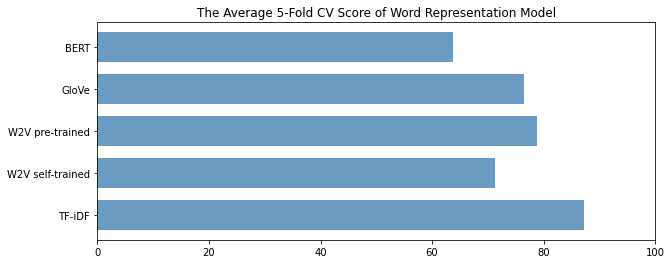

In [60]:
plt.figure(figsize=(10,4))

# Plot the score of each model
plt.barh(range(5), [score_tf.mean()*100,score_w2v_self.mean()*100,score_w2v_pre_train.mean()*100,score_glov.mean()*100,score_bert.mean()*100], height=0.7, color='steelblue', alpha=0.8)
plt.yticks(range(5), ['TF-iDF','W2V self-trained', 'W2V pre-trained','GloVe','BERT'])
plt.xlim(0,100)
plt.title("The Average 5-Fold CV Score of Word Representation Model")
plt.savefig(r'CV Score of Word Representation Model"(after semi).png',bbox_inches='tight')

## 4. Generate Text Feature for the Final DataFrame in Hybrid

In [61]:
#The best model selected
tf = TfidfVectorizer(ngram_range=(1,2),max_features=9500)
tf_matrix = tf.fit_transform(X_train_des)

#Generate descriptions in training and testing to matrices
def tf_vectoriser(df,indices):
    des = [' '.join(x) for x in df['description']]
    tf_trans = tf.transform(des)
    tf_df = tf_trans.toarray()
    tf_df = pd.DataFrame(tf_df)
    tf_df.index = indices
    return tf_df

X_train_des = tf_vectoriser(X_train,train_indices)
X_test_des = tf_vectoriser(X_test,test_indices)

In [63]:
#Combine with the numberical features to form the final dataset
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

def form_final_df(des_df,num_df,label):
    #normalise amount and balance to values between 0 and 1
    num_df['amount_std'] = scaler.fit_transform(num_df['amount'].values.reshape(-1,1))
    num_df['balance_std'] = scaler.fit_transform(num_df['balance'].values.reshape(-1,1))
    #combine numerical and text features
    X = pd.concat([des_df,num_df[['amount_std','balance_std','debit_binary', 'foreign_binary','financing_binary','account_binary','hmrc_vat','hmrc_corp','hmrc_paye','week_of_month_2','week_of_month_3','week_of_month_4','token_length']]], axis=1)
    X_withlabels = pd.concat([X,label], axis=1)
    return X_withlabels

#Form training and testing datasets
Train = form_final_df(X_train_des,X_train,y_train)
Test = form_final_df(X_test_des,X_test,y_test)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [66]:
Train.to_csv(r'Train_hybrid_updated.csv')
Test.to_csv(r'Test_hybrid_updated.csv')

In [56]:
df_4.to_csv(r'df_hybrid_undersampled.csv',index = False)